# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [2]:
def get_simple():
    X = np.linspace(-3, 3, 11)
    y = np.sin(X)
    y+=np.random.randn(11)*.2
    return X, y

### **1. Training of SVRs via Constrained Optimization** <a class="anchor" id="optim"></a>

Throughout this notebook, we assume $\mathbf{X} \in \mathbb{R}^{N \times D}$ as $N \times D$ matrix of training examples and $\mathbf{t} \in \mathbb{R}^N$ as $N$-dimensional vector of training targets.
To express the dual SVR in standard form, we express the kernel matrix $K \in \mathbb{R}^{NxN}$ such that each entry is $K_{ij} = k(\mathbf{x}_i , \mathbf{x}_j)$.

The dual form of the SVR was introduced as:

  \begin{align*}
  \widetilde{L}(\mathbf a,\widehat{\mathbf a}) =& - \frac{1}{2}  \sum_{n=1}^N  \sum_{m=1}^N (a_n - \widehat a _n) (a_m - \widehat a _m)k(\mathbf x_n,\mathbf x_m)\\ &- \epsilon  \sum_{n=1}^N (a_n + \widehat a _n) +  \sum_{m=1}^N (a_n - \widehat a _n) t_n
  \end{align*}


> To simplify the mathematical procedure, transform it first into matrix multiplication form!

  \begin{align*}
  \widetilde{L}(\mathbf a,\widehat{\mathbf a}) =& - \frac{1}{2}  (\mathbf a - \widehat{\mathbf a})^T \mathbf K (\mathbf a - \widehat{\mathbf a})\\ &- \epsilon  (\mathbf a + \widehat{\mathbf a})^T * \mathbf {1} +   (\mathbf a - \widehat{\mathbf a})^T \mathbf t
  \end{align*}

The optimization objective is given by:
\begin{align}
\max_{\boldsymbol{a}}\widetilde{L}(\mathbf a,\widehat{\mathbf a})
\end{align}
subject to
\begin{align}
  0 \leqslant a_n \leqslant C\\
  0 \leqslant \widehat a_n \leqslant C
\end{align}

Once, we have found the optimum $\boldsymbol{a}$, the prediction function of the SVR is given by
\begin{equation}
y(\mathbf x) = \sum_{n=1}^N (a_n- \widehat a _n)k (\mathbf x, \mathbf x _n) +b
\end{equation}
where $b \in \mathbb{R}$ is the bias parameter.

We can estimate $b$ by considering a data point for which $0 < a_n < C$, which must have $\xi_n = 0$. Therefore this point must satisfy $\epsilon + y_n - t_n = 0$.
\begin{equation}
b = \frac{1}{N_\mathcal{M}} \sum_{n \in \mathcal{M}} \left( t_n - \epsilon - \sum_{m \in \mathcal{S}} (a_m- \widehat a _m)k (\mathbf x_n, \mathbf x _m)\right).
\end{equation}
Analogous results can be obtained by considering a point for which $0 < \widehat a_n < C$. $\mathcal{S} \subseteq \{1, \dots, N\}$ denotes the set of support vectors and $\mathcal{M} \subseteq \{1, \dots, N\}$ denotes the set of support vectors lying
on the margin with $N_\mathcal{M} = |\mathcal{M}|$.

> Below, implement a SVR for a simple regression problem by solving the dual problem above.
> For optimization make use of `scipy` and its [Optimization Module](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp).

In [3]:
class RBFKernel:
    def __init__(self, gamma=1):
        """Computes RBF kernel matrix between X_1 and X_2.

        Args:
            gamma (float): Hyperparameter of RBF kernel.
        """
        self.gamma = gamma

    def __call__(self, X_1, X_2):
        """Computes the kernel matrix.

        Args:
            X_1 (array-like): Input samples in shape (N, D).
            X_2 (array-like): Input samples in shape (N, D).

        Returns:
            ndarray: Kernel matrix of shape shape (N, M)
        """
        return np.exp(-self.gamma * np.sum((X_1[:, None] - X_2[None]) ** 2, axis=2))

In [72]:
class SVR:
    def __init__(self, kernel_func, eps=0.2, C=1.0, random_state=42):
        """Implementation of a C-SVM for regression.
        Args:
            C (float): Regularization parameter. The strength of the regularization is inversely
                proportional to C. Must be strictly positive. (default=1.0)
            eps (float): ...
            kernel_func (callable): Specifies the kernel type to be used in the algorithm.
            random_state (int): Random state to ensure reproducibility when initializing  a values.
        """
        self.C = C
        self.eps = eps
        self.kernel_func = kernel_func
        self.random_state = random_state
        np.random.seed(self.random_state)


    def fit(self, X, t):
        """Fit the SVM model according to the given training data.

        Args:
            X (array-like): Training samples of shape (N, D).
            t (array-like): Training targets of shape (N).

        Returns:
            self: The fitted SVM object.
        """
        K = self.kernel_func(X, X)
        
        
        # Optimization
        # Step 1: Define the loss function and its gradient.
        def loss(a):
            # Compute loss for given a.
            a_hat = a[:len(a)//2]
            a_normal = a[len(a)//2:]
            diff_a = (a_normal - a_hat)
            return - 0.5 * diff_a.T @ K @ diff_a - self.eps * (a_normal + a_hat).T @ np.ones_like(diff_a) + diff_a.T @ t  # dual form

        def jac(a):
            # Compute gradient of loss function w.r.t. a. -> 2*N lang; gradient != jacobian
            # concat grad w.r.t a_hat and a_normal
            a_hat = a[:len(a)//2]
            a_normal = a[len(a)//2:]
          
            deriv_t_a = -a_normal.T @ K  + 0.5 * a_hat.T @ K + 0.5 * a_hat @ K - self.eps + t
            deriv_t_a_hat = a_normal.T @ K - a_hat @ K - self.eps - t
            jac = np.concatenate([deriv_t_a_hat, deriv_t_a])
            return jac

        # Step 2: Define the Constraints.
        # We need to write the contraints in matrix notation:
        # - for inequalities: Ax <= b
        # - for eqalities cx = d
        # Note that x = a in our example.
        # 'fun' in the constraints needs to be adapted such that
        # 0 <= lambda a: ....

        # Set up the constraints:
        # Example: {'type': 'eq', 'fun': lambda a: a**2, 'jac': lambda a: 2*a}
        
        constraints = [{'type': 'ineq', 'fun': lambda a: a, 'jac': lambda a: np.eye(len(a))}]  # 0 <= a_hat
        #constraints += [{'type': 'ineq', 'fun': lambda a: a[len(a)//2:], 'jac': lambda a: np.eye(len(a)//2)}]  # 0 <= a_normal
        
        constraints += [{'type': 'ineq', 'fun': lambda a: self.C - a, 'jac': lambda a: -np.eye(len(a))}]   # a_hat <= C
        #constraints += [{'type': 'ineq', 'fun': lambda a: self.C - a[len(a)//2:], 'jac': lambda a: -np.eye(len(a)//2)}]   # a_normal <= C

        #constraints += [{'type': 'eq', 'fun': lambda a: np.sum(a[len(a)//2:] - a[:len(a)//2]), 'jac': lambda a: np.concatenate([-np.ones(len(a)//2), np.ones(len(a)//2)])}]  # sum(a_normal - a_hat) = 0


        # Optimize the a vector.
        a0 = np.random.rand(2 * len(X))  # initial guess
        self.a_ = minimize(loss, a0, jac=jac, constraints=constraints, method='SLSQP').x
        self.a_[np.isclose(self.a_, 0)] = 0  # zero out nearly zeros
        self.a_[np.isclose(self.a_, self.C)] = self.C  # round the ones that are nearly C


        # Determine indices of support vectors.
        a_hat = self.a_[:len(self.a_)//2]
        a_normal = self.a_[len(self.a_)//2:]

        self.support_index_hat_ = np.where(a_hat == 0)[0]
        self.support_index_normal_ = np.where(a_normal == 0)[0]
        self.support_ = np.where((a_hat != 0) | (a_normal != 0))[0]
        # Determine indices of support vectors that lie on the margin.
        # support vectors are those with a_hat != 0 OR a_normal != 0
        self.on_margin_hat = np.where((a_hat != 0) & (a_hat <= self.C))[0]
        self.on_margin_normal = np.where((a_normal != 0) & (a_normal <= self.C))[0]
        self.on_margin_ = np.where(((a_hat != 0) | (a_normal != 0)) & ((a_hat <= self.C) | (a_normal <= self.C)))[0]
        

        # Determine bias parameter.
        # on_margin is subset of support vectors: != 0 & <= C
        self.b = 1/len(self.on_margin_hat) \
            * np.sum(t[self.on_margin_hat] \
                     - self.eps - np.sum(a_hat[self.support_index_hat_] \
                                            @ K[self.support_index_hat_][:, self.on_margin_hat], axis=0))


        # Store support vectors including their targets and a.
        self.support_vectors = X[self.support_]
        self.support_targets = t[self.support_]
        self.support_a = self.a_[self.support_]

        return self

    def predict(self, X):
        """Perform regression on samples in X.

        Args:
            X (array-like): Input samples whose targets are to be predicted.

        Returns:
            y (array-like): Predicted target of samples in X.
        """

        a_hat = self.a_[:len(self.a_)//2]
        a_normal = self.a_[len(self.a_)//2:]
        K = self.kernel_func(X.reshape(-1,1), self.support_vectors)
        return (a_normal - a_hat).reshape(1,-1) @ K + self.b 

> Train the SVR on the given dataset and plot its support vectors.

(11,)
[-2.36208683 -3.05951633 -3.29014187 -3.25097797 -2.78027359 -1.3850467
  0.61482754  2.00702906  2.44172068  2.28312071  1.59174661]


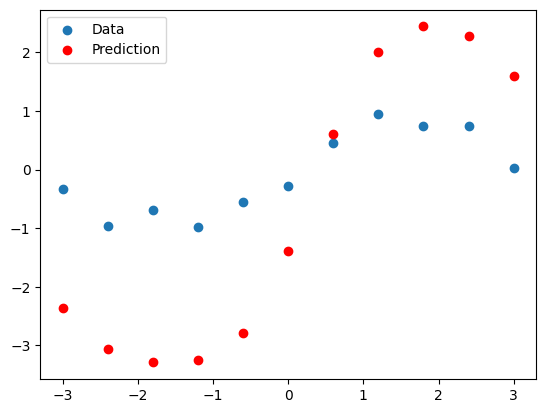

In [80]:
X, y = get_simple()
print(X.shape)

svr = SVR(RBFKernel(gamma=1), eps=0.2, C=1.0)
svr.fit(X.reshape(-1,1), y)
#FIXME: sign is wrong and scale is too large
y_pred = -svr.predict(X).squeeze()
print(y_pred)
plt.scatter(X, y)
plt.scatter(X, y_pred, color='red')
plt.legend(['Data', 'Prediction'])